In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

from data import utils
from data import load_raw_data

/work/ariyanzarei/SorghumSegmentation/TreePartNet/pointnet2_ops_lib/pointnet2_ops/pointnet2_utils.py:15: UserWarning: Unable to load pointnet2_ops cpp extension. JIT Compiling.
  warnings.warn("Unable to load pointnet2_ops cpp extension. JIT Compiling.")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


WARNING - 2022-11-02 11:21:42,191 - _axes - *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
WARNING - 2022-11-02 11:21:42,193 - _axes - *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


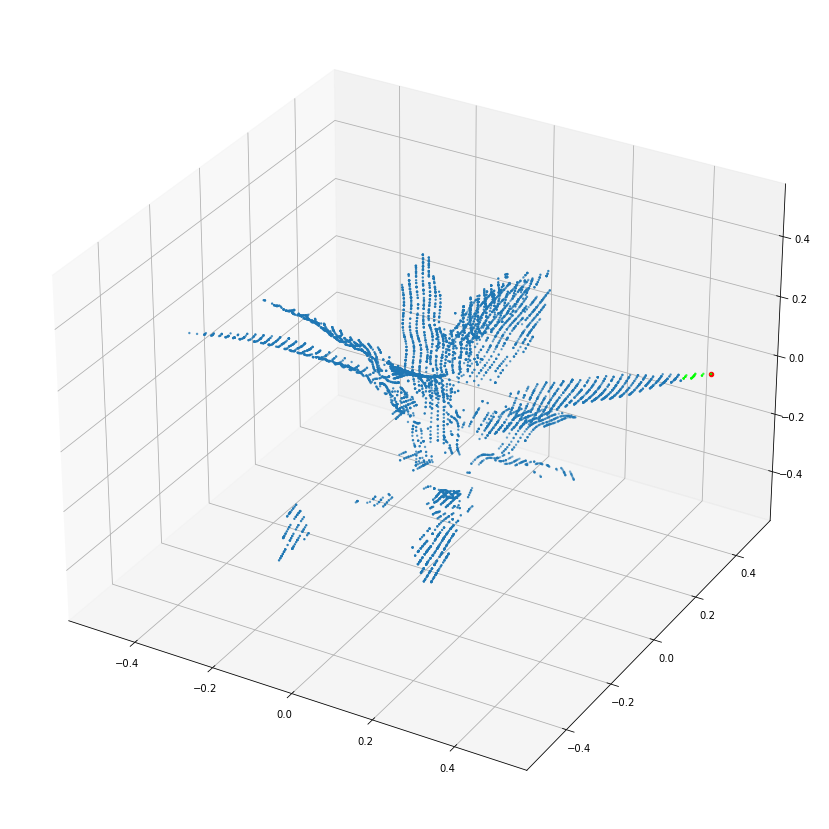

In [16]:
pcd = load_raw_data.load_pcd_plyfile_new_approach("/space/ariyanzarei/sorghum_segmentation/dataset/synthetic/2022-09-29/PointCloud/S11_34281.ply", True, std_coef=0.2)
points = pcd['points']
labels = pcd['labels'].squeeze()

maxs = np.max(points,0)

ind = np.where(points[:,2] == maxs[2])[0][0]

mins = np.min(points, axis=0)
maxs = np.max(points, axis=0)
mins = np.repeat(np.expand_dims(mins,0),points.shape[0],axis=0)
maxs = np.repeat(np.expand_dims(maxs,0),points.shape[0],axis=0)

points = (points - mins) / (maxs - mins) - 0.5

dist_threshold = 0.07
close_ind = np.where(np.sqrt(np.sum((points - points[ind])**2,1))<dist_threshold)
far_ind = np.where(np.sqrt(np.sum((points - points[ind])**2,1))>=dist_threshold)

d_colors = utils.distinct_colors(len(set(labels.tolist())))
colors = np.zeros((labels.shape[0], 3))
for i, l in enumerate(list(set(labels.tolist()))):
    colors[labels == l, :] = d_colors[i]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[far_ind,2],points[far_ind,0],points[far_ind,1], s=2)
ax.scatter(points[ind,2],points[ind,0],points[ind,1], s=20, c=(1,0,0))
ax.scatter(points[close_ind,2],points[close_ind,0],points[close_ind,1], s=2, c=(0,1,0))
plt.show()


[4.09009127e+05 3.66005563e+06 8.66288096e-02] [4.09010047e+05 3.66005626e+06 1.10193360e+00]


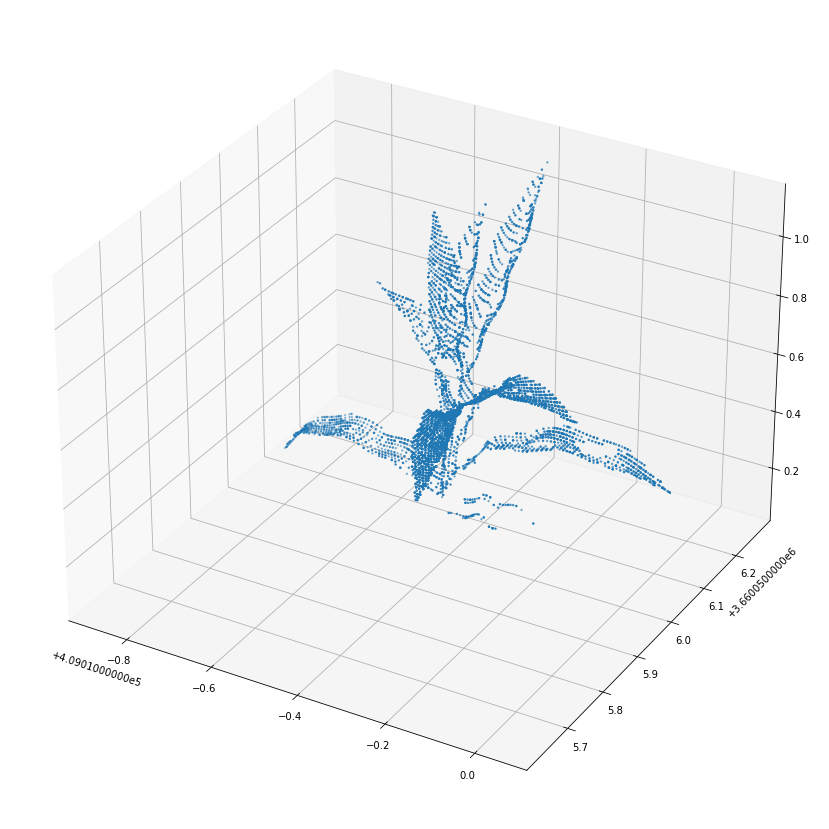

In [19]:
pcd = load_raw_data.load_pcd_plyfile_new_approach("/space/ariyanzarei/sorghum_segmentation/S11_1.ply", True, std_coef=0.2)
points = pcd['points']
labels = pcd['labels'].squeeze()

# points, _, _ = load_raw_data.load_ply_file_points("/space/ariyanzarei/sorghum_segmentation/dataset/real_data/2020-08-06/PI_678197_3822_330758913924.ply")


# maxs = np.max(points,0)

# ind = np.where(points[:,2] == maxs[2])[0][0]

mins = np.min(points, axis=0)
maxs = np.max(points, axis=0)
# mins = np.repeat(np.expand_dims(mins,0),points.shape[0],axis=0)
# maxs = np.repeat(np.expand_dims(maxs,0),points.shape[0],axis=0)

# points = (points - mins) / (maxs - mins) - 0.5
print(mins, maxs)

# d_colors = utils.distinct_colors(len(set(labels.tolist())))
# colors = np.zeros((labels.shape[0], 3))
# for i, l in enumerate(list(set(labels.tolist()))):
#     colors[labels == l, :] = d_colors[i]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0],points[:,1],points[:,2], s=2)
# ax.scatter(points[ind,2],points[ind,0],points[ind,1], s=20, c=(1,0,0))
plt.show()
